In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Change the following to match the simulation data

# 7 SNARE data

nrod = 7
rtmd_arr = [2.27]
delta_h = [2.1]
run_list = [[13]]
seed_list = [[546]]
t_hem_list = [[1499]]
t_ihem_list = [[0]]
t_fus_list = [[0]]


folder_path = 'E:/fusion_forces/fixed_rad/cut_snare/'

index = 0

file_prefix = 'ves_ves_cutsnare_nostaple_rtmd_ini_%.2f_deltah_%.2f_Nunzip_10.00_lp_0.50_nrod_%d_rod_r_0.38_dves_55.9_tension_0.05_'%(rtmd_arr[index],delta_h[index],nrod)
path_prefix = folder_path + file_prefix
run_arr = run_list[index]
seed_arr = seed_list[index]
t_hem_arr = t_hem_list[index]
t_ihem_arr = t_ihem_list[index]
t_fus_arr = t_fus_list[index]

In [3]:
dt = 0.068/1000 # timestep in microseconds
frame_dt = 20000 # in steps
check_period = 200 # in steps

# Function Definitions

In [4]:
def get_tmd_pos(run, seed, t_start, t_stop):
    
    linker_up_dir = np.load(path_prefix+'run_%d_dir_up_%d.npy'%(run, seed), allow_pickle=True)
    linker_dn_dir = np.load(path_prefix+'run_%d_dir_dn_%d.npy'%(run, seed), allow_pickle=True)
    
    linker_up_pos = np.load(path_prefix+'run_%d_ct_up_%d.npy'%(run, seed), allow_pickle=True) # in units of sigma
    linker_dn_pos = np.load(path_prefix+'run_%d_ct_dn_%d.npy'%(run, seed), allow_pickle=True) # in units of sigma

    tmd_up_pos = - linker_up_dir + linker_up_pos
    tmd_dn_pos = - linker_dn_dir + linker_dn_pos

    tmd_up_pos = tmd_up_pos[t_start:t_stop, ...]
    tmd_dn_pos = tmd_dn_pos[t_start:t_stop, ...]
    
    tmd_up_pos = tmd_up_pos*0.88
    tmd_dn_pos = tmd_dn_pos*0.88 # in nm

    return tmd_up_pos, tmd_dn_pos

In [5]:
def get_linker_force_cart(run, seed, t_start, t_stop):
   
    # Load linker forces
    linker_up_f_comp = np.load(path_prefix+'run_%d_force_up_%d.npy'%(run, seed), allow_pickle=True)
    linker_dn_f_comp = np.load(path_prefix+'run_%d_force_dn_%d.npy'%(run, seed), allow_pickle=True)
    linker_up_f_comp = linker_up_f_comp[t_start:t_stop, ...]
    linker_dn_f_comp = linker_dn_f_comp[t_start:t_stop, ...]
    linker_up_f_comp = -linker_up_f_comp*0.6*4.1/0.88 # in pN
    linker_dn_f_comp = -linker_dn_f_comp*0.6*4.1/0.88 # in pN
    linker_up_f = np.linalg.norm(linker_up_f_comp, axis=2)
    linker_dn_f = np.linalg.norm(linker_dn_f_comp, axis=2)
    
    return linker_up_f, linker_dn_f, linker_up_f_comp, linker_dn_f_comp # in pN

In [6]:
def get_snare_force_tot(run, seed, t_start, t_stop):
    
    # Load SNARE COM forces (including linker forces)
    snare_data = np.load(path_prefix+'run_%d_snare_force_%d.npy'%(run, seed), allow_pickle=True)
    snare_data = snare_data[t_start:t_stop, ...]
    # Convert SNARE COM forces to pN
    snare_data = snare_data*0.6*4.1/0.88
    
    return snare_data # in pN

In [7]:
def get_snare_entropic_force(snare_data, linker_up_f_comp, linker_dn_f_comp):
    snare_f = snare_data[:] - linker_up_f_comp[:] - linker_dn_f_comp[:] # Compute total force on the SNARE, excluding linker forces (in pN)
    return snare_f

In [8]:
def get_ring_center(snare_ctd_pos):
    # Find the centroid of the SNARE CTDs
    snare_ctd_centroid = np.mean(snare_ctd_pos, axis=1)
    return snare_ctd_centroid

In [9]:
def get_cterm_pos(run, seed, t_start, t_stop):
    
    # Load linker positions for all other snares
    linker_up_pos = np.load(path_prefix+'run_%d_ct_up_%d.npy'%(run, seed), allow_pickle=True) # in units of sigma
    linker_dn_pos = np.load(path_prefix+'run_%d_ct_dn_%d.npy'%(run, seed), allow_pickle=True) # in units of sigma
    linker_up_pos = linker_up_pos[t_start:t_stop, ...]
    linker_dn_pos = linker_dn_pos[t_start:t_stop, ...]

    # Find the mean position of the CTD for each snare
    snare_ctd_pos = (linker_up_pos + linker_dn_pos)/2 * 0.88 # in nm
    snare_ctd_pos_avg = np.mean(snare_ctd_pos, axis=0) # in nm
    
    return snare_ctd_pos, snare_ctd_pos_avg

In [10]:
def get_ring_radius(snare_ctd_pos, snare_ctd_centroid):
    # Compute the distance of each SNARE CTD from the centroid
    snare_r_centroid = snare_ctd_pos - snare_ctd_centroid[:, np.newaxis, :]
    # Compute the magnitude of the distance of each SNARE CTD from the centroid (in nm)
    snare_r_centroid_magn = np.sqrt(snare_r_centroid[..., 0]**2 + snare_r_centroid[..., 1]**2) # in units of sigma
    #snare_r_centroid_magn = snare_r_centroid_magn*0.88 # in nm
    # compute the mean ring radius
    #snare_r_centroid_magn_mean = np.mean(snare_r_centroid_magn, axis=0)
    #snare_r_centroid_magn_std = np.std(snare_r_centroid_magn, axis=0)
    #snare_r_maxmin = np.max(snare_r_centroid_magn, axis=0)/np.min(snare_r_centroid_magn, axis=0)
    #return snare_r_centroid_magn_mean, snare_r_centroid_magn_std, snare_r_maxmin
    return snare_r_centroid_magn

In [11]:
def get_linker_norm(run, seed, t_start, t_stop):
    
    # Load linker direction vectors (in units of sigma)
    linker_up_dir = np.load(path_prefix+'run_%d_dir_up_%d.npy'%(run, seed), allow_pickle=True)
    linker_dn_dir = np.load(path_prefix+'run_%d_dir_dn_%d.npy'%(run, seed), allow_pickle=True)
    linker_up_dir = linker_up_dir[t_start:t_stop, ...]
    linker_dn_dir = linker_dn_dir[t_start:t_stop, ...]
    #print(linker_up_dir.shape)
    #print(linker_dn_dir.shape)
    
    # Compute the linker vector magnitudes (in units of sigma)
    linker_up_magn = np.linalg.norm(linker_up_dir, axis=2, keepdims=True)
    linker_dn_magn = np.linalg.norm(linker_dn_dir, axis=2, keepdims=True)
   
    # Check that both linker_up_dir and linker_dn_dir are pointing from CTD to TMD
    # z_TMD - z_CTD > 0 for the up linkers, so linker_up_dir[2] should be positive
    # z_TMD - z_CTD < 0 for the dn linkers, so linker_dn_dir[2] should be negative
    if np.mean(linker_up_dir[:10,:,2]) < 0: 
        #print('Inverting linker_up_dir')
        linker_up_dir = -linker_up_dir
    if np.mean(linker_dn_dir[:10,:,2]) > 0: 
        #print('Inverting linker_dn_dir')
        linker_dn_dir = -linker_dn_dir

    # Compute the linker unit vectors (pointing from CTD to TMD)
    linker_up_dir_norm = linker_up_dir / (linker_up_magn + 1e-10) # add 1e-10 to avoid division by zero
    linker_dn_dir_norm = linker_dn_dir / (linker_dn_magn + 1e-10) # add 1e-10 to avoid division by zero

    return linker_up_dir_norm, linker_dn_dir_norm

In [12]:
def get_polar_dir(tmd_pos_avg, ori):

    ori = get_ring_center(tmd_pos_avg)
    
    # Translate linker COM positions relative to the new origin
    tmd_pos_avg = tmd_pos_avg - ori[:, None, :]
    
    # Get unit vectors for the r and theta directions for each SNARE
    rx = tmd_pos_avg[..., 0]/np.sqrt(tmd_pos_avg[..., 0]**2 + tmd_pos_avg[..., 1]**2)
    ry = tmd_pos_avg[..., 1]/np.sqrt(tmd_pos_avg[..., 0]**2 + tmd_pos_avg[..., 1]**2)

    thetax = -ry
    thetay = rx

    return rx, ry, thetax, thetay

In [13]:
def get_polar_force(snare_f_x, snare_f_y, snare_f_z, rx, ry, thetax, thetay):
    
    # Compute the force components in the r and theta directions
    snare_f_r = snare_f_x*rx + snare_f_y*ry
    snare_f_theta = snare_f_x*thetax + snare_f_y*thetay
    return snare_f_r, snare_f_theta, snare_f_z

In [14]:
def get_polar_pos(snare_ctd_pos, rx, ry, thetax, thetay):
    
    # Get unit vectors for the r and theta directions for each SNARE
    r = snare_ctd_pos[..., 0]*rx + snare_ctd_pos[..., 1]*ry
    theta = snare_ctd_pos[..., 0]*thetax + snare_ctd_pos[..., 1]*thetay

    return r, theta

In [15]:
from scipy.signal import correlate

def autocorr(x):
    
    #Normalize the result to have it range from -1 to 1, so the autocorrelation at lag 0 is exactly 1
    norm = np.sum(x ** 2)
    
    # The 'same' mode returns the central part of the correlation
    # that is the same size as the input signal.
    acf = correlate(x, x, mode='same') / norm
    
    # Since the result includes negative lags, we only want the second half
    # which corresponds to the positive lags (including lag 0 at the center)
    acf = acf[acf.size // 2:]
    return acf

# Calculations

In [16]:
snare_f_x_arr_all = []
snare_f_y_arr_all = []
snare_f_z_arr_all = []
snare_data_x_arr_all = []
snare_data_y_arr_all = []
snare_data_z_arr_all = []
linker_up_f_x_arr_all = []
linker_up_f_y_arr_all = []
linker_up_f_z_arr_all = []
linker_dn_f_x_arr_all = []
linker_dn_f_y_arr_all = []
linker_dn_f_z_arr_all = []
linker_up_arr_all = []
linker_dn_arr_all = []
snare_ctd_pos_arr_all = []
snare_ctd_pos_avg_arr = []
tmd_pos_up_arr = []
tmd_pos_dn_arr = []

ring_radius_arr = []
ring_radius_std_arr = []
#ring_radius_maxmin_arr = []
n_measurements_arr = []

In [17]:
for i in range(len(run_arr)):
    run = run_arr[i]
    seed = seed_arr[i]
    print('run = %d, seed = %d'%(run, seed))

    frame_start = 0
    frame_stop = t_hem_arr[i]

    t_start = int((frame_start)*frame_dt/check_period)
    t_stop = int((frame_stop-1)*frame_dt/check_period)

    linker_up_f_all, linker_dn_f_all, linker_up_f_comp_all, linker_dn_f_comp_all = get_linker_force_cart(run, seed, t_start, t_stop)
    snare_data_all = get_snare_force_tot(run, seed, t_start, t_stop)
    snare_f_all = get_snare_entropic_force(snare_data_all, linker_up_f_comp_all, linker_dn_f_comp_all)
    snare_ctd_pos, snare_ctd_pos_avg = get_cterm_pos(run, seed, t_start, t_stop)
    tmd_pos_up, tmd_pos_dn = get_tmd_pos(run, seed, t_start, t_stop)
    tmd_pos_avg = (tmd_pos_up + tmd_pos_dn)/2
    #ring_radius, ring_radius_std, ring_radius_maxmin = get_ring_radius(snare_ctd_pos, get_ring_center(snare_ctd_pos))
    ring_radius = get_ring_radius(tmd_pos_avg, get_ring_center(tmd_pos_avg))

    n_measurements = np.shape(snare_data_all)[0]
    n_measurements_arr.append(n_measurements)

    snare_f_x_arr_all.append(snare_f_all[..., 0])
    snare_f_y_arr_all.append(snare_f_all[..., 1])
    snare_f_z_arr_all.append(snare_f_all[..., 2])
    snare_data_x_arr_all.append(snare_data_all[..., 0])
    snare_data_y_arr_all.append(snare_data_all[..., 1])
    snare_data_z_arr_all.append(snare_data_all[..., 2])
    linker_up_f_x_arr_all.append(linker_up_f_comp_all[..., 0])
    linker_up_f_y_arr_all.append(linker_up_f_comp_all[..., 1])
    linker_up_f_z_arr_all.append(linker_up_f_comp_all[..., 2])
    linker_dn_f_x_arr_all.append(linker_dn_f_comp_all[..., 0])
    linker_dn_f_y_arr_all.append(linker_dn_f_comp_all[..., 1])
    linker_dn_f_z_arr_all.append(linker_dn_f_comp_all[..., 2])
    linker_up_arr_all.append(linker_up_f_all)
    linker_dn_arr_all.append(linker_dn_f_all)
    snare_ctd_pos_arr_all.append(snare_ctd_pos)
    snare_ctd_pos_avg_arr.append(snare_ctd_pos_avg)
    tmd_pos_up_arr.append(tmd_pos_up)
    tmd_pos_dn_arr.append(tmd_pos_dn)

    ring_radius_arr.append(ring_radius)
    #ring_radius_std_arr.append(ring_radius_std)
    #ring_radius_maxmin_arr.append(ring_radius_maxmin)
    
    del tmd_pos_up, tmd_pos_dn, tmd_pos_avg, snare_ctd_pos, snare_ctd_pos_avg, ring_radius
    del linker_up_f_comp_all, linker_dn_f_comp_all, snare_data_all, snare_f_all, linker_up_f_all, linker_dn_f_all
    #del ring_radius, ring_radius_std, ring_radius_maxmin
    

run = 13, seed = 546


In [18]:
# Flatten all force arrays into 2D arrays of shape (n_measurements, nsnare) 

snare_f_x_arr_all = np.concatenate(snare_f_x_arr_all, axis=0)
snare_f_y_arr_all = np.concatenate(snare_f_y_arr_all, axis=0)
snare_f_z_arr_all = np.concatenate(snare_f_z_arr_all, axis=0)
snare_data_x_arr_all = np.concatenate(snare_data_x_arr_all, axis=0)
snare_data_y_arr_all = np.concatenate(snare_data_y_arr_all, axis=0)
snare_data_z_arr_all = np.concatenate(snare_data_z_arr_all, axis=0)
linker_up_f_x_arr_all = np.concatenate(linker_up_f_x_arr_all, axis=0)
linker_up_f_y_arr_all = np.concatenate(linker_up_f_y_arr_all, axis=0)
linker_up_f_z_arr_all = np.concatenate(linker_up_f_z_arr_all, axis=0)
linker_dn_f_x_arr_all = np.concatenate(linker_dn_f_x_arr_all, axis=0)
linker_dn_f_y_arr_all = np.concatenate(linker_dn_f_y_arr_all, axis=0)
linker_dn_f_z_arr_all = np.concatenate(linker_dn_f_z_arr_all, axis=0)
linker_up_arr_all = np.concatenate(linker_up_arr_all, axis=0)
linker_dn_arr_all = np.concatenate(linker_dn_arr_all, axis=0)
snare_ctd_pos_arr_all = np.concatenate(snare_ctd_pos_arr_all, axis=0)
tmd_pos_up_arr = np.concatenate(tmd_pos_up_arr, axis=0)
tmd_pos_dn_arr = np.concatenate(tmd_pos_dn_arr, axis=0)
ring_radius_arr = np.concatenate(ring_radius_arr, axis=0)

In [19]:
# Compute total linker forces (sum of up and down linkers)
linker_f_x_arr_all = linker_up_f_x_arr_all + linker_dn_f_x_arr_all
linker_f_y_arr_all = linker_up_f_y_arr_all + linker_dn_f_y_arr_all
linker_f_z_arr_all = linker_up_f_z_arr_all + linker_dn_f_z_arr_all

In [20]:
# Compute averages and standard deviations ISNARE

corr = 1
n_measurements = np.sum(n_measurements_arr) # total number of measurements
print('Number of measurements per SNARE = %d'%n_measurements)
print('Measurement time: %.2f us'%(n_measurements*dt*check_period))

Number of measurements per SNARE = 147501
Measurement time: 2006.01 us


## AVERAGES OVER ALL SNARES

### COM forces

In [21]:
print('COM force x')
print('Mean: %.2f pN'%np.mean(snare_data_x_arr_all))
print('SD: %.2f pN'%np.std(snare_data_x_arr_all))
print('SEM: %.2f pN'%(np.std(snare_data_x_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_data_x_arr_all))

print('COM force y')
print('Mean: %.2f pN'%np.mean(snare_data_y_arr_all))
print('SD: %.2f pN'%np.std(snare_data_y_arr_all))
print('SEM: %.2f pN'%(np.std(snare_data_y_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_data_y_arr_all))

print('COM force z')
print('Mean: %.2f pN'%np.mean(snare_data_z_arr_all))
print('SD: %.2f pN'%np.std(snare_data_z_arr_all))
print('SEM: %.2f pN'%(np.std(snare_data_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_data_z_arr_all))

COM force x
Mean: 0.00 pN
SD: 9.72 pN
SEM: 0.03 pN
Median: -0.00 pN
COM force y
Mean: -0.01 pN
SD: 9.72 pN
SEM: 0.03 pN
Median: -0.02 pN
COM force z
Mean: -0.01 pN
SD: 11.23 pN
SEM: 0.03 pN
Median: -0.02 pN


### Wall forces

In [22]:
print('Wall force f_x')
print('Mean: %.2f pN'%np.mean(snare_f_x_arr_all))
print('SD: %.2f pN'%np.std(snare_f_x_arr_all))
print('SEM: %.2f pN'%(np.std(snare_f_x_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_f_x_arr_all))

print('Wall force f_y')
print('Mean: %.2f pN'%np.mean(snare_f_y_arr_all))
print('SD: %.2f pN'%np.std(snare_f_y_arr_all))
print('SEM: %.2f pN'%(np.std(snare_f_y_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_f_y_arr_all))

print('Wall force f_z')
print('Mean: %.2f pN'%np.mean(snare_f_z_arr_all))
print('SD: %.2f pN'%np.std(snare_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(snare_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_f_z_arr_all))

Wall force f_x
Mean: 0.04 pN
SD: 9.56 pN
SEM: 0.02 pN
Median: 0.01 pN
Wall force f_y
Mean: 0.03 pN
SD: 9.54 pN
SEM: 0.02 pN
Median: 0.01 pN
Wall force f_z
Mean: 0.20 pN
SD: 10.84 pN
SEM: 0.03 pN
Median: 0.16 pN


### Linker forces

In [23]:
print('x up linker force T_x')
print('Mean: %.2f pN'%np.mean(linker_up_f_x_arr_all))
print('SD: %.2f pN'%np.std(linker_up_f_x_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_f_x_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_f_x_arr_all))

print('y up linker force T_y')
print('Mean: %.2f pN'%np.mean(linker_up_f_y_arr_all))
print('SD: %.2f pN'%np.std(linker_up_f_y_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_f_y_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_f_y_arr_all))

print('z up linker force T_z')
print('Mean: %.2f pN'%np.mean(linker_up_f_z_arr_all))
print('SD: %.2f pN'%np.std(linker_up_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_f_z_arr_all))

print('x down linker force T_x')
print('Mean: %.2f pN'%np.mean(linker_dn_f_x_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_f_x_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_f_x_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_f_x_arr_all))

print('y down linker force T_y')
print('Mean: %.2f pN'%np.mean(linker_dn_f_y_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_f_y_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_f_y_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_f_y_arr_all))

print('z down linker force T_z')
print('Mean: %.2f pN'%np.mean(linker_dn_f_z_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_f_z_arr_all))

print('x both linker forces T_x')
print('Mean: %.2f pN'%np.mean(linker_f_x_arr_all))
print('SD: %.2f pN'%np.std(linker_f_x_arr_all))
print('SEM: %.2f pN'%(np.std(linker_f_x_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_f_x_arr_all))

print('y both linker forces T_y')
print('Mean: %.2f pN'%np.mean(linker_f_y_arr_all))
print('SD: %.2f pN'%np.std(linker_f_y_arr_all))
print('SEM: %.2f pN'%(np.std(linker_f_y_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_f_y_arr_all))

print('z both linker forces T_z')
print('Mean: %.2f pN'%np.mean(linker_f_z_arr_all))
print('SD: %.2f pN'%np.std(linker_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(linker_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_f_z_arr_all))

print('Mean zippering force up T_up')
print('Mean: %.2f pN'%np.mean(linker_up_arr_all))
print('SD: %.2f pN'%np.std(linker_up_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_arr_all))

print('Mean zippering force down T_dn')
print('Mean: %.2f pN'%np.mean(linker_dn_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_arr_all))

x up linker force T_x
Mean: 0.31 pN
SD: 5.64 pN
SEM: 0.01 pN
Median: 0.30 pN
y up linker force T_y
Mean: 0.46 pN
SD: 5.59 pN
SEM: 0.01 pN
Median: 0.43 pN
z up linker force T_z
Mean: 16.63 pN
SD: 5.72 pN
SEM: 0.01 pN
Median: 15.88 pN
x down linker force T_x
Mean: -0.35 pN
SD: 5.66 pN
SEM: 0.01 pN
Median: -0.32 pN
y down linker force T_y
Mean: -0.50 pN
SD: 5.66 pN
SEM: 0.01 pN
Median: -0.48 pN
z down linker force T_z
Mean: -16.85 pN
SD: 5.69 pN
SEM: 0.01 pN
Median: -16.15 pN
x both linker forces T_x
Mean: -0.03 pN
SD: 7.89 pN
SEM: 0.02 pN
Median: -0.04 pN
y both linker forces T_y
Mean: -0.05 pN
SD: 7.85 pN
SEM: 0.02 pN
Median: -0.04 pN
z both linker forces T_z
Mean: -0.21 pN
SD: 7.23 pN
SEM: 0.02 pN
Median: -0.22 pN
Mean zippering force up T_up
Mean: 24.78 pN
SD: 15.99 pN
SEM: 0.04 pN
Median: 16.92 pN
Mean zippering force down T_dn
Mean: 25.05 pN
SD: 16.13 pN
SEM: 0.04 pN
Median: 17.00 pN


## AVERAGES OVER EACH SNARE

### COM forces

In [24]:
'''
print('COM force x')
print('Mean (pN): ', np.mean(snare_data_x_arr_all, axis=0))
print('SD (pN): ', np.std(snare_data_x_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_data_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_data_x_arr_all, axis=0))

print('\nCOM force y')
print('Mean (pN): ', np.mean(snare_data_y_arr_all, axis=0))
print('SD (pN): ', np.std(snare_data_y_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_data_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_data_y_arr_all, axis=0))

print('\nCOM force z')
print('Mean (pN): ', np.mean(snare_data_z_arr_all, axis=0))
print('SD (pN): ', np.std(snare_data_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_data_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_data_z_arr_all, axis=0))
'''

"\nprint('COM force x')\nprint('Mean (pN): ', np.mean(snare_data_x_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_data_x_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_data_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_data_x_arr_all, axis=0))\n\nprint('\nCOM force y')\nprint('Mean (pN): ', np.mean(snare_data_y_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_data_y_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_data_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_data_y_arr_all, axis=0))\n\nprint('\nCOM force z')\nprint('Mean (pN): ', np.mean(snare_data_z_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_data_z_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_data_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_data_z_arr_all, axis=0))\n"

### Wall forces

In [25]:
'''
print('Wall force f_x')
print('Mean (pN): ', np.mean(snare_f_x_arr_all, axis=0))
print('SD (pN): ', np.std(snare_f_x_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_f_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_f_x_arr_all, axis=0))

print('Wall force f_y')
print('Mean (pN): ', np.mean(snare_f_y_arr_all, axis=0))
print('SD (pN): ', np.std(snare_f_y_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_f_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_f_y_arr_all, axis=0))

print('Wall force f_z')
print('Mean (pN): ', np.mean(snare_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(snare_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_f_z_arr_all, axis=0))
'''

"\nprint('Wall force f_x')\nprint('Mean (pN): ', np.mean(snare_f_x_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_f_x_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_f_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_f_x_arr_all, axis=0))\n\nprint('Wall force f_y')\nprint('Mean (pN): ', np.mean(snare_f_y_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_f_y_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_f_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_f_y_arr_all, axis=0))\n\nprint('Wall force f_z')\nprint('Mean (pN): ', np.mean(snare_f_z_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_f_z_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_f_z_arr_all, axis=0))\n"

### Linker forces

In [26]:
'''
print('x up linker force T_x')
print('Mean (pN): ', np.mean(linker_up_f_x_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_f_x_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_f_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_f_x_arr_all, axis=0))

print('y up linker force T_y')
print('Mean (pN): ', np.mean(linker_up_f_y_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_f_y_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_f_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_f_y_arr_all, axis=0))

print('z up linker force T_z')
print('Mean (pN): ', np.mean(linker_up_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_f_z_arr_all, axis=0))

print('x down linker force T_x')
print('Mean (pN): ', np.mean(linker_dn_f_x_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_f_x_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_f_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_f_x_arr_all, axis=0))

print('y down linker force T_y')
print('Mean (pN): ', np.mean(linker_dn_f_y_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_f_y_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_f_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_f_y_arr_all, axis=0))

print('z down linker force T_z')
print('Mean (pN): ', np.mean(linker_dn_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_f_z_arr_all, axis=0))

print('x both linker forces T_x')
print('Mean (pN): ', np.mean(linker_f_x_arr_all, axis=0))
print('SD (pN): ', np.std(linker_f_x_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_f_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_f_x_arr_all, axis=0))

print('y both linker forces T_y')
print('Mean (pN): ', np.mean(linker_f_y_arr_all, axis=0))
print('SD (pN): ', np.std(linker_f_y_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_f_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_f_y_arr_all, axis=0))

print('z both linker forces T_z')
print('Mean (pN): ', np.mean(linker_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(linker_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_f_z_arr_all, axis=0))

print('Mean zippering force up T_up')
print('Mean (pN): ', np.mean(linker_up_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_arr_all, axis=0))

print('Mean zippering force down T_dn')
print('Mean (pN): ', np.mean(linker_dn_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_arr_all, axis=0))
'''

"\nprint('x up linker force T_x')\nprint('Mean (pN): ', np.mean(linker_up_f_x_arr_all, axis=0))\nprint('SD (pN): ', np.std(linker_up_f_x_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(linker_up_f_x_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(linker_up_f_x_arr_all, axis=0))\n\nprint('y up linker force T_y')\nprint('Mean (pN): ', np.mean(linker_up_f_y_arr_all, axis=0))\nprint('SD (pN): ', np.std(linker_up_f_y_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(linker_up_f_y_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(linker_up_f_y_arr_all, axis=0))\n\nprint('z up linker force T_z')\nprint('Mean (pN): ', np.mean(linker_up_f_z_arr_all, axis=0))\nprint('SD (pN): ', np.std(linker_up_f_z_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(linker_up_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(linker_up_f_z_arr_all, axis=0))\n\nprint('x down linker force T_x')\nprint('Mean (pN): ', np.mea

In [27]:
# Calculate mean linker force magnitude in the xy plane
linker_f_xy_arr_all = np.sqrt(linker_f_x_arr_all**2 + linker_f_y_arr_all**2)
print(np.shape(linker_f_xy_arr_all))
linker_f_xy_arr_avg = np.mean(linker_f_xy_arr_all, axis=0)
print(np.shape(linker_f_xy_arr_avg))
print('Mean linker force magnitude in the xy plane')
print('Mean (pN): ', linker_f_xy_arr_avg)

(147501, 7)
(7,)
Mean linker force magnitude in the xy plane
Mean (pN):  [9.63992218 9.64080964 9.61088975 9.62064021 9.61003046 9.65660143
 9.63133738]


In [28]:
# Mean CTD positions
snare_ctd_pos_avg_arr = np.mean(snare_ctd_pos_avg_arr, axis=0)
ori = get_ring_center(snare_ctd_pos_avg_arr)
print(ori)

[-0.43994431 -0.85340018 -0.64890414 -0.22945571 -0.64682295 -0.03736102
 -1.27130661]


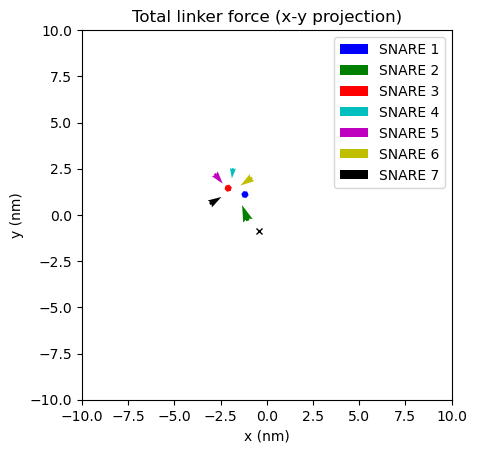

In [29]:
# Plot the unit vectors of each snare's linker forces
font_title = {  'weight': 'bold',
                'size': 10}
font_axis = {   'weight': 'normal',
                'size': 10}

plt.figure()
c_arr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g']
for i in range(np.shape(linker_f_x_arr_all)[1]):
    plt.quiver(snare_ctd_pos_avg_arr[i,0], snare_ctd_pos_avg_arr[i,1], np.mean(linker_f_x_arr_all[:, i]), np.mean(linker_f_y_arr_all[:, i]), angles='xy', scale_units='xy', scale=1.5, color=c_arr[i], label='SNARE %d'%(i+1), width=0.02)
plt.plot(ori[0], ori[1], 'kx', markersize=5)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x (nm)', fontdict=font_axis)
plt.ylabel('y (nm)', fontdict=font_axis)
# Remove tick labels
#plt.xticks([])
#plt.yticks([])
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Total linker force (x-y projection)')
#plt.title('Top linker force directions')
#plt.title('Bottom linker force directions')
plt.show()

# FIXED POLAR COORDINATES

In [30]:
# Calculate the linker force magnitude in the xy plane along the mean direction
linker_f_xy_magn_avg = []
for i in range(np.shape(linker_f_x_arr_all)[1]):
    linker_f_xy_magn_avg.append(np.sqrt(np.mean(linker_f_x_arr_all[:, i])**2 + np.mean(linker_f_y_arr_all[:, i])**2))
print('Linker force magnitude in the mean direction in xy plane')
print('Mean (pN): ',linker_f_xy_magn_avg)

Linker force magnitude in the mean direction in xy plane
Mean (pN):  [0.4985277037605265, 1.3506436843546208, 0.17621971139686557, 0.8269932827147056, 1.0301670111271766, 1.138300865278398, 1.0987315176112242]


In [31]:
# Get the unit vectors of the linker forces in the radial and theta directions
'''
ld_dir_rad_x = -np.mean(linker_f_x_arr_all, axis = 0)/linker_f_xy_magn_avg
ld_dir_rad_y = -np.mean(linker_f_y_arr_all, axis = 0)/linker_f_xy_magn_avg
ld_dir_rad_magn = np.sqrt(ld_dir_rad_x**2 + ld_dir_rad_y**2)
print('Linker direction in the radial direction')
print('Mean (pN): ', ld_dir_rad_magn)
ld_dir_theta_x = -ld_dir_rad_y
ld_dir_theta_y = ld_dir_rad_x
'''

"\nld_dir_rad_x = -np.mean(linker_f_x_arr_all, axis = 0)/linker_f_xy_magn_avg\nld_dir_rad_y = -np.mean(linker_f_y_arr_all, axis = 0)/linker_f_xy_magn_avg\nld_dir_rad_magn = np.sqrt(ld_dir_rad_x**2 + ld_dir_rad_y**2)\nprint('Linker direction in the radial direction')\nprint('Mean (pN): ', ld_dir_rad_magn)\nld_dir_theta_x = -ld_dir_rad_y\nld_dir_theta_y = ld_dir_rad_x\n"

In [32]:
# Find the mean position of each SNARE's TMD in cartesian coords
tmd_pos_avg_arr = (tmd_pos_up_arr + tmd_pos_dn_arr)/2
tmd_pos_avg = np.mean(tmd_pos_avg_arr, axis=0)
print(np.shape(tmd_pos_avg_arr))
print(np.shape(tmd_pos_avg))

(147501, 7, 3)
(7, 3)


In [33]:
# Get radial and theta unit vectors pointing from the ring center to the TMDs
ld_dir_rad_x, ld_dir_rad_y, ld_dir_theta_x, ld_dir_theta_y = get_polar_dir(tmd_pos_avg_arr, get_ring_center(tmd_pos_avg_arr))

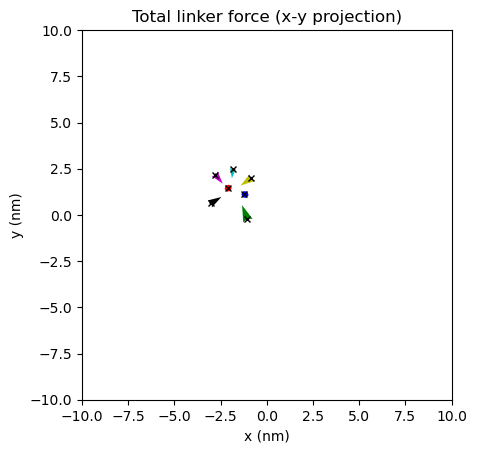

In [34]:
# Plot the unit vectors of each snare's linker forces
plt.figure()
c_arr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g']
for i in range(np.shape(linker_f_x_arr_all)[1]):
    plt.quiver(snare_ctd_pos_avg_arr[i,0], snare_ctd_pos_avg_arr[i,1], np.mean(linker_f_x_arr_all[:, i]), np.mean(linker_f_y_arr_all[:, i]), angles='xy', scale_units='xy', scale=1.5, color=c_arr[i], label='SNARE %d'%(i+1), width=0.02)
    #plt.quiver(tmd_pos_avg[i, 0], tmd_pos_avg[i, 1], np.mean(ld_dir_rad_x[i]), np.mean(ld_dir_rad_y[i]), angles='xy', scale_units='xy', scale=0.5, color=c_arr[i], label='SNARE %d'%(i+1))
    plt.plot(tmd_pos_avg[i, 0], tmd_pos_avg[i, 1], 'x', markersize=5, color='k')
#plt.plot(ori[0], ori[1], 'kx', markersize=5)
#plt.plot(0, 0, 'k.', markersize=8)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x (nm)', fontdict=font_axis)
plt.ylabel('y (nm)', fontdict=font_axis)
# Remove tick labels
#plt.xticks([])
#plt.yticks([])
#plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Total linker force (x-y projection)')
#plt.title('Top linker force directions')
#plt.title('Bottom linker force directions')
plt.show()

In [35]:
# Convert all forces to polar coordinates
snare_data_rad_arr_all, snare_data_theta_arr_all, snare_data_z_arr_all = get_polar_force(snare_data_x_arr_all, snare_data_y_arr_all, snare_data_z_arr_all, ld_dir_rad_x, ld_dir_rad_y, ld_dir_theta_x, ld_dir_theta_y)
snare_f_rad_arr_all, snare_f_theta_arr_all, snare_f_z_arr_all = get_polar_force(snare_f_x_arr_all, snare_f_y_arr_all, snare_f_z_arr_all, ld_dir_rad_x, ld_dir_rad_y, ld_dir_theta_x, ld_dir_theta_y)
linker_up_f_rad_arr_all, linker_up_f_theta_arr_all, linker_up_f_z_arr_all = get_polar_force(linker_up_f_x_arr_all, linker_up_f_y_arr_all, linker_up_f_z_arr_all, ld_dir_rad_x, ld_dir_rad_y, ld_dir_theta_x, ld_dir_theta_y)
linker_dn_f_rad_arr_all, linker_dn_f_theta_arr_all, linker_dn_f_z_arr_all = get_polar_force(linker_dn_f_x_arr_all, linker_dn_f_y_arr_all, linker_dn_f_z_arr_all, ld_dir_rad_x, ld_dir_rad_y, ld_dir_theta_x, ld_dir_theta_y)

In [36]:
# Compute total linker forces (sum of up and down linkers)
linker_f_rad_arr_all = linker_up_f_rad_arr_all + linker_dn_f_rad_arr_all
linker_f_theta_arr_all = linker_up_f_theta_arr_all + linker_dn_f_theta_arr_all
linker_f_z_arr_all = linker_up_f_z_arr_all + linker_dn_f_z_arr_all

## AVERAGES OVER ALL SNARES

### COM forces

In [37]:
print('COM force rad')
print('Mean: %.2f pN'%np.mean(snare_data_rad_arr_all))
print('SD: %.2f pN'%np.std(snare_data_rad_arr_all))
print('SEM: %.2f pN'%(np.std(snare_data_rad_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_data_rad_arr_all))

print('\nCOM force theta')
print('Mean: %.2f pN'%np.mean(snare_data_theta_arr_all))
print('SD: %.2f pN'%np.std(snare_data_theta_arr_all))
print('SEM: %.2f pN'%(np.std(snare_data_theta_arr_all)/np.sqrt(n_measurements/corr)))  
print('Median: %.2f pN'%np.median(snare_data_theta_arr_all))

print('\nCOM force z')
print('Mean: %.2f pN'%np.mean(snare_data_z_arr_all))
print('SD: %.2f pN'%np.std(snare_data_z_arr_all))
print('SEM: %.2f pN'%(np.std(snare_data_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_data_z_arr_all))

COM force rad
Mean: -0.02 pN
SD: 9.79 pN
SEM: 0.03 pN
Median: -0.19 pN

COM force theta
Mean: 0.00 pN
SD: 9.64 pN
SEM: 0.03 pN
Median: -0.01 pN

COM force z
Mean: -0.01 pN
SD: 11.23 pN
SEM: 0.03 pN
Median: -0.02 pN


### Wall forces

In [38]:
print('Wall force f_rad')
print('Mean: %.2f pN'%np.mean(snare_f_rad_arr_all))
print('SD: %.2f pN'%np.std(snare_f_rad_arr_all))
print('SEM: %.2f pN'%(np.std(snare_f_rad_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_f_rad_arr_all))

print('\nWall force f_theta')
print('Mean: %.2f pN'%np.mean(snare_f_theta_arr_all))
print('SD: %.2f pN'%np.std(snare_f_theta_arr_all))
print('SEM: %.2f pN'%(np.std(snare_f_theta_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_f_theta_arr_all))

print('\nWall force f_z')
print('Mean: %.2f pN'%np.mean(snare_f_z_arr_all))
print('SD: %.2f pN'%np.std(snare_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(snare_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(snare_f_z_arr_all))

Wall force f_rad
Mean: 3.35 pN
SD: 9.26 pN
SEM: 0.02 pN
Median: 3.21 pN

Wall force f_theta
Mean: 0.06 pN
SD: 9.25 pN
SEM: 0.02 pN
Median: 0.04 pN

Wall force f_z
Mean: 0.20 pN
SD: 10.84 pN
SEM: 0.03 pN
Median: 0.16 pN


### Linker forces

In [39]:
# Up linker forces
print('rad up linker force T_rad')
print('Mean: %.2f pN'%np.mean(linker_up_f_rad_arr_all))
print('SD: %.2f pN'%np.std(linker_up_f_rad_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_f_rad_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_f_rad_arr_all))

print('\ntheta up linker force T_theta')
print('Mean: %.2f pN'%np.mean(linker_up_f_theta_arr_all))
print('SD: %.2f pN'%np.std(linker_up_f_theta_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_f_theta_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_f_theta_arr_all))

print('\nz up linker force T_z')
print('Mean: %.2f pN'%np.mean(linker_up_f_z_arr_all))
print('SD: %.2f pN'%np.std(linker_up_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_f_z_arr_all))

# Down linker forces
print('\nrad down linker force T_rad')
print('Mean: %.2f pN'%np.mean(linker_dn_f_rad_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_f_rad_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_f_rad_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_f_rad_arr_all))

print('\ntheta down linker force T_theta')
print('Mean: %.2f pN'%np.mean(linker_dn_f_theta_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_f_theta_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_f_theta_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_f_theta_arr_all))

print('\nz down linker force T_z')
print('Mean: %.2f pN'%np.mean(linker_dn_f_z_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_f_z_arr_all))

# Both linker forces
print('\nrad both linker forces T_rad')
print('Mean: %.2f pN'%np.mean(linker_f_rad_arr_all))
print('SD: %.2f pN'%np.std(linker_f_rad_arr_all))
print('SEM: %.2f pN'%(np.std(linker_f_rad_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_f_rad_arr_all))

print('\ntheta both linker forces T_theta')
print('Mean: %.2f pN'%np.mean(linker_f_theta_arr_all))
print('SD: %.2f pN'%np.std(linker_f_theta_arr_all))
print('SEM: %.2f pN'%(np.std(linker_f_theta_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_f_theta_arr_all))

print('\nz both linker forces T_z')
print('Mean: %.2f pN'%np.mean(linker_f_z_arr_all))
print('SD: %.2f pN'%np.std(linker_f_z_arr_all))
print('SEM: %.2f pN'%(np.std(linker_f_z_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_f_z_arr_all))

# Zippering forces
print('\nMean zippering force up T_up')
print('Mean: %.2f pN'%np.mean(linker_up_arr_all))
print('SD: %.2f pN'%np.std(linker_up_arr_all))
print('SEM: %.2f pN'%(np.std(linker_up_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_up_arr_all))

print('\nMean zippering force down T_dn')
print('Mean: %.2f pN'%np.mean(linker_dn_arr_all))
print('SD: %.2f pN'%np.std(linker_dn_arr_all))
print('SEM: %.2f pN'%(np.std(linker_dn_arr_all)/np.sqrt(n_measurements/corr)))
print('Median: %.2f pN'%np.median(linker_dn_arr_all))

rad up linker force T_rad
Mean: -1.81 pN
SD: 5.48 pN
SEM: 0.01 pN
Median: -1.60 pN

theta up linker force T_theta
Mean: -0.06 pN
SD: 5.49 pN
SEM: 0.01 pN
Median: -0.11 pN

z up linker force T_z
Mean: 16.63 pN
SD: 5.72 pN
SEM: 0.01 pN
Median: 15.88 pN

rad down linker force T_rad
Mean: -1.56 pN
SD: 5.55 pN
SEM: 0.01 pN
Median: -1.40 pN

theta down linker force T_theta
Mean: -0.00 pN
SD: 5.58 pN
SEM: 0.01 pN
Median: -0.06 pN

z down linker force T_z
Mean: -16.85 pN
SD: 5.69 pN
SEM: 0.01 pN
Median: -16.15 pN

rad both linker forces T_rad
Mean: -3.37 pN
SD: 7.49 pN
SEM: 0.02 pN
Median: -3.23 pN

theta both linker forces T_theta
Mean: -0.06 pN
SD: 7.50 pN
SEM: 0.02 pN
Median: -0.09 pN

z both linker forces T_z
Mean: -0.21 pN
SD: 7.23 pN
SEM: 0.02 pN
Median: -0.22 pN

Mean zippering force up T_up
Mean: 24.78 pN
SD: 15.99 pN
SEM: 0.04 pN
Median: 16.92 pN

Mean zippering force down T_dn
Mean: 25.05 pN
SD: 16.13 pN
SEM: 0.04 pN
Median: 17.00 pN


## AVERAGES OVER EACH SNARE

### COM forces

In [40]:
'''
print('COM force rad')
print('Mean (pN): ', np.mean(snare_data_rad_arr_all, axis=0))
print('SD (pN): ', np.std(snare_data_rad_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_data_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_data_rad_arr_all, axis=0))

print('\nCOM force theta')
print('Mean (pN): ', np.mean(snare_data_theta_arr_all, axis=0))
print('SD (pN): ', np.std(snare_data_theta_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_data_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_data_theta_arr_all, axis=0))

print('\nCOM force z')
print('Mean (pN): ', np.mean(snare_data_z_arr_all, axis=0))
print('SD (pN): ', np.std(snare_data_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_data_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_data_z_arr_all, axis=0))
'''

"\nprint('COM force rad')\nprint('Mean (pN): ', np.mean(snare_data_rad_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_data_rad_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_data_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_data_rad_arr_all, axis=0))\n\nprint('\nCOM force theta')\nprint('Mean (pN): ', np.mean(snare_data_theta_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_data_theta_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_data_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_data_theta_arr_all, axis=0))\n\nprint('\nCOM force z')\nprint('Mean (pN): ', np.mean(snare_data_z_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_data_z_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_data_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_data_z_arr_all, axis=0))\n"

### Wall forces

In [41]:
'''
print('Wall force f_rad')
print('Mean (pN): ', np.mean(snare_f_rad_arr_all, axis=0))
print('SD (pN): ', np.std(snare_f_rad_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_f_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_f_rad_arr_all, axis=0))

print('\nWall force f_theta')
print('Mean (pN): ', np.mean(snare_f_theta_arr_all, axis=0))
print('SD (pN): ', np.std(snare_f_theta_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_f_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_f_theta_arr_all, axis=0))

print('\nWall force f_z')
print('Mean (pN): ', np.mean(snare_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(snare_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(snare_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(snare_f_z_arr_all, axis=0))
'''

"\nprint('Wall force f_rad')\nprint('Mean (pN): ', np.mean(snare_f_rad_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_f_rad_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_f_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_f_rad_arr_all, axis=0))\n\nprint('\nWall force f_theta')\nprint('Mean (pN): ', np.mean(snare_f_theta_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_f_theta_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_f_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_f_theta_arr_all, axis=0))\n\nprint('\nWall force f_z')\nprint('Mean (pN): ', np.mean(snare_f_z_arr_all, axis=0))\nprint('SD (pN): ', np.std(snare_f_z_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(snare_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(snare_f_z_arr_all, axis=0))\n"

### Linker forces

In [42]:
'''
print('\nrad up linker force T_rad')
print('Mean (pN): ', np.mean(linker_up_f_rad_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_f_rad_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_f_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_f_rad_arr_all, axis=0))

print('\ntheta up linker force T_theta')
print('Mean (pN): ', np.mean(linker_up_f_theta_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_f_theta_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_f_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_f_theta_arr_all, axis=0))

print('\nz up linker force T_z')
print('Mean (pN): ', np.mean(linker_up_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(linker_up_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_up_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_up_f_z_arr_all, axis=0))

print('\nrad down linker force T_rad')
print('Mean (pN): ', np.mean(linker_dn_f_rad_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_f_rad_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_f_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_f_rad_arr_all, axis=0))

print('\ntheta down linker force T_theta')
print('Mean (pN): ', np.mean(linker_dn_f_theta_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_f_theta_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_f_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_f_theta_arr_all, axis=0))

print('\nz down linker force T_z')
print('Mean (pN): ', np.mean(linker_dn_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(linker_dn_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_dn_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_dn_f_z_arr_all, axis=0))

print('\nrad both linker forces T_rad')
print('Mean (pN): ', np.mean(linker_f_rad_arr_all, axis=0))
print('SD (pN): ', np.std(linker_f_rad_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_f_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_f_rad_arr_all, axis=0))

print('\ntheta both linker forces T_theta')
print('Mean (pN): ', np.mean(linker_f_theta_arr_all, axis=0))
print('SD (pN): ', np.std(linker_f_theta_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_f_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_f_theta_arr_all, axis=0))

print('\nz both linker forces T_z')
print('Mean (pN): ', np.mean(linker_f_z_arr_all, axis=0))
print('SD (pN): ', np.std(linker_f_z_arr_all, axis=0))
print('SEM (pN): ', (np.std(linker_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))
print('Median (pN): ', np.median(linker_f_z_arr_all, axis=0))
'''

"\nprint('\nrad up linker force T_rad')\nprint('Mean (pN): ', np.mean(linker_up_f_rad_arr_all, axis=0))\nprint('SD (pN): ', np.std(linker_up_f_rad_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(linker_up_f_rad_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(linker_up_f_rad_arr_all, axis=0))\n\nprint('\ntheta up linker force T_theta')\nprint('Mean (pN): ', np.mean(linker_up_f_theta_arr_all, axis=0))\nprint('SD (pN): ', np.std(linker_up_f_theta_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(linker_up_f_theta_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(linker_up_f_theta_arr_all, axis=0))\n\nprint('\nz up linker force T_z')\nprint('Mean (pN): ', np.mean(linker_up_f_z_arr_all, axis=0))\nprint('SD (pN): ', np.std(linker_up_f_z_arr_all, axis=0))\nprint('SEM (pN): ', (np.std(linker_up_f_z_arr_all, axis=0)/np.sqrt(n_measurements/corr)))\nprint('Median (pN): ', np.median(linker_up_f_z_arr_all, axis=0))\n\nprint('\nrad down l

In [43]:
# Get the C-term position in cartesial coords relative to the TMD position
#snare_ctd_pos_arr_all_rel_tmd = snare_ctd_pos_arr_all - tmd_pos_avg_arr

In [44]:
# Convert the C terminal positions to polar coordinates given the unit vector in the radial direction
#snare_ctd_pos_rad_arr_all, snare_ctd_pos_theta_arr_all = get_polar_pos(snare_ctd_pos_arr_all_rel_tmd, ld_dir_rad_x, ld_dir_rad_y, ld_dir_theta_x, ld_dir_theta_y) 

# SAVE DATA

In [45]:
ring_rad_avg = np.mean(ring_radius_arr)
ring_rad_std = np.std(ring_radius_arr)

T_zip_avg = np.mean((linker_up_arr_all+linker_dn_arr_all)/2) 
T_zip_std = np.std((linker_up_arr_all+linker_dn_arr_all)/2)

F_squeeze_up = np.sum(linker_up_f_z_arr_all, axis = 1)
F_squeeze_dn = np.sum(linker_dn_f_z_arr_all, axis = 1)
F_squeeze_avg = np.mean((F_squeeze_up - F_squeeze_dn)/2)
F_squeeze_std = np.std((F_squeeze_up - F_squeeze_dn)/2)

f_squeeze_avg = np.mean((linker_up_f_z_arr_all - linker_dn_f_z_arr_all)/2)
f_squeeze_std = np.std((linker_up_f_z_arr_all - linker_dn_f_z_arr_all)/2)

T_rad_tot_avg = np.mean(linker_f_rad_arr_all)
T_rad_tot_std = np.std(linker_f_rad_arr_all)
T_theta_tot_avg = np.mean(linker_f_theta_arr_all)
T_theta_tot_std = np.std(linker_f_theta_arr_all)

fent_rad_avg = np.mean(snare_f_rad_arr_all)
fent_rad_std = np.std(snare_f_rad_arr_all)
fent_theta_avg = np.mean(snare_f_theta_arr_all)
fent_theta_std = np.std(snare_f_theta_arr_all)
fent_z_avg = np.mean(snare_f_z_arr_all)
fent_z_std = np.std(snare_f_z_arr_all)

In [46]:
print(ring_rad_avg)

3.529654144520199


In [47]:
# Save the data to a .txt file

fname = 'force_data_cutsnare_nostaple_nrod_%d_rtmd_ini_%.2f.txt'%(nrod, rtmd_arr[index])

with open(fname, 'w') as file:
    file.write("Number of SNAREs\n")
    file.write(f"{nrod}\n")
    file.write("TMD ring constraint (nm)\n")
    file.write(f"{rtmd_arr[index]*0.88}\n")
    file.write("Number of measurements per SNARE\n")
    file.write(f"{n_measurements}\n")
    file.write("TMD ring radius (nm)\n")
    file.write(f"{ring_rad_avg}\n")
    file.write(f"{ring_rad_std}\n")
    file.write("Zippering force per LD (pN)\n")
    file.write(f"{T_zip_avg}\n")
    file.write(f"{T_zip_std}\n")
    file.write("Total squeezing force (pN)\n")
    file.write(f"{F_squeeze_avg}\n")
    file.write(f"{F_squeeze_std}\n")
    file.write("Squeezing force per LD (pN)\n")
    file.write(f"{f_squeeze_avg}\n")
    file.write(f"{f_squeeze_std}\n")
    file.write("Radial linker force (both LDs) (pN)\n")
    file.write(f"{T_rad_tot_avg}\n")
    file.write(f"{T_rad_tot_std}\n")
    file.write("Theta linker force (both LDs) (pN)\n")
    file.write(f"{T_theta_tot_avg}\n")
    file.write(f"{T_theta_tot_std}\n")
    file.write("Radial entropic force (pN)\n")
    file.write(f"{fent_rad_avg}\n")
    file.write(f"{fent_rad_std}\n")
    file.write("Theta entropic force (pN)\n")
    file.write(f"{fent_theta_avg}\n")
    file.write(f"{fent_theta_std}\n")
    file.write("Z entropic force (pN)\n")
    file.write(f"{fent_z_avg}\n")
    file.write(f"{fent_z_std}\n")


# PLOTS

In [48]:
# Plot settings
interval = 1 # plotting interval;
#t_plot = np.arange(t_start, t_stop-2900)*dt_save*0.068*1e-3 # in microseconds
t_plot = np.arange(0, linker_f_rad_arr_all.shape[0])*check_period*0.068*1e-3 # in microseconds
print(t_plot.shape)

(147501,)


In [49]:
isnare = 5

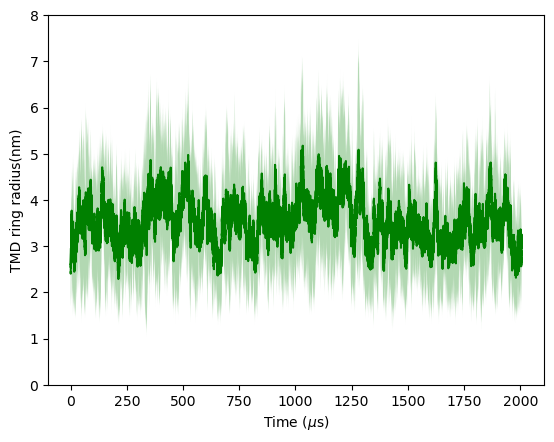

In [50]:
# Plot the mean TMD ring radius
ring_radius_arr_avg = np.mean(ring_radius_arr, axis=1)
ring_rad_interval = np.std(ring_radius_arr, axis=1)

plt.figure()
plt.plot(t_plot, ring_radius_arr_avg, color='g')
plt.fill_between(t_plot, ring_radius_arr_avg - ring_rad_interval, ring_radius_arr_avg + ring_rad_interval, color='g', alpha=0.3, edgecolor='none')
plt.xlabel('Time ($\mu$s)', fontdict=font_axis)
plt.ylabel('TMD ring radius(nm)', fontdict=font_axis)
#plt.title('Ring radius', fontdict=font_title)
#plt.xlim(0,1)
plt.ylim(0,8)
#plt.legend()
plt.show()


In [51]:
window_size = 500
ring_radius_movavg = np.convolve(ring_radius_arr_avg, np.ones(window_size)/window_size, mode='valid')
ring_radius_movstd = np.array([np.std(ring_radius_arr_avg[i:i+window_size]) for i in range(len(ring_radius_arr_avg) - window_size + 1)])
# Adjust t_plot to match the length of the moving average
t_plot_movavg = t_plot[(window_size-1):]  # Adjust time array to match the moving average length

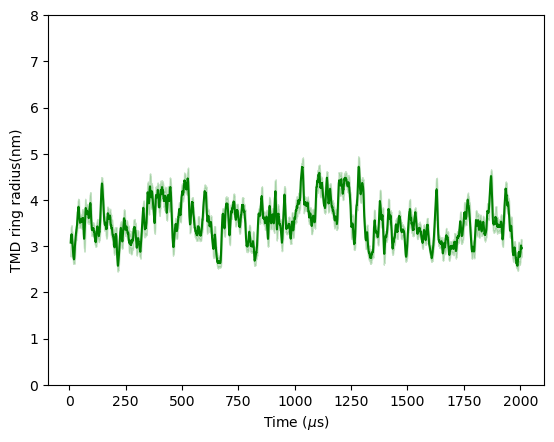

In [52]:
plt.figure()
plt.plot(t_plot_movavg, ring_radius_movavg, color='g')
plt.fill_between(t_plot_movavg, ring_radius_movavg - ring_radius_movstd, ring_radius_movavg + ring_radius_movstd, color='g', alpha=0.2, label='±1 SD')
#plt.fill_between(t_plot, ring_radius_arr_avg - ring_rad_interval, ring_radius_arr_avg + ring_rad_interval, color='g', alpha=0.3, edgecolor='none')
#plt.fill_between(t_plot, ring_radius_arr_avg - ring_rad_interval, ring_radius_arr_avg + ring_rad_interval, color='g', alpha=0.3)
plt.xlabel('Time ($\mu$s)', fontdict=font_axis)
plt.ylabel('TMD ring radius(nm)', fontdict=font_axis)
#plt.title('Ring radius', fontdict=font_title)
#plt.xlim(0,1000)
plt.ylim(0,8)
#plt.legend()
plt.show()

In [53]:
from scipy.io import savemat
zip1 = np.concatenate((t_plot_movavg[:, np.newaxis],ring_radius_movavg[:,np.newaxis]),axis = 1)
zip1 = np.concatenate((zip1, ring_radius_movstd[:,np.newaxis]), axis = 1)
print(np.shape(zip1))
# Save entropic force to a .mat file
savemat(file_prefix + 'ring_rad_movavg.mat', {'array': zip1})

(147002, 3)


In [54]:
zip2 = np.concatenate((t_plot[:, np.newaxis],(snare_f_rad_arr_all[:,isnare])[:,np.newaxis]),axis = 1)
print(np.shape(zip2))
savemat(file_prefix + 'fent_rad.mat', {'array': zip2})

(147501, 2)


In [55]:
print(np.mean(snare_f_rad_arr_all[75000:-1,isnare]))

3.129208948564227


In [56]:
'''
plt.plot(snare_ctd_pos_rad_arr_all[:, isnare], linker_f_rad_arr_all[:, isnare], 'o', markersize=1)
plt.xlabel('r (nm)', fontdict=font_axis)
plt.ylabel('Radial linker force (pN)', fontdict=font_axis)
plt.title('Radial linker force vs radial C-term position')
plt.xlim(-1, 2.5)
plt.ylim(-80, 20)
'''

"\nplt.plot(snare_ctd_pos_rad_arr_all[:, isnare], linker_f_rad_arr_all[:, isnare], 'o', markersize=1)\nplt.xlabel('r (nm)', fontdict=font_axis)\nplt.ylabel('Radial linker force (pN)', fontdict=font_axis)\nplt.title('Radial linker force vs radial C-term position')\nplt.xlim(-1, 2.5)\nplt.ylim(-80, 20)\n"

In [57]:
# Plot a 2D histogram of the radial linker force vs radial position
'''
plt.figure()
counts2, x_edges2, y_edges2, patches2 = plt.hist2d(snare_ctd_pos_rad_arr_all[:, isnare], linker_f_rad_arr_all[:, isnare], bins=(np.arange(-100, 100, 0.02), np.arange(-100, 100, 1)), cmap='viridis', density=True)
plt.xlabel('r (nm)', fontdict=font_axis)
plt.ylabel('Radial linker force (pN)', fontdict=font_axis)
plt.ylim(-30,10)
plt.xlim(-1,2.5)
plt.title('Radial linker force vs radial C-term position')
# Set equal aspect ratio
#plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar()
cbar.set_label('Probability density')
'''

"\nplt.figure()\ncounts2, x_edges2, y_edges2, patches2 = plt.hist2d(snare_ctd_pos_rad_arr_all[:, isnare], linker_f_rad_arr_all[:, isnare], bins=(np.arange(-100, 100, 0.02), np.arange(-100, 100, 1)), cmap='viridis', density=True)\nplt.xlabel('r (nm)', fontdict=font_axis)\nplt.ylabel('Radial linker force (pN)', fontdict=font_axis)\nplt.ylim(-30,10)\nplt.xlim(-1,2.5)\nplt.title('Radial linker force vs radial C-term position')\n# Set equal aspect ratio\n#plt.gca().set_aspect('equal', adjustable='box')\ncbar = plt.colorbar()\ncbar.set_label('Probability density')\n"

In [58]:
# Plot the radial linker force distribution for one snare
'''
#plt.hist(snare_f_rad_arr_all[:,isnare], bins=np.arange(-100,101,2), density=True, alpha=0.6, color='g', label='Radial SNARE force')
#plt.hist(-(linker_up_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='b', label='Top radial linker force')
#plt.hist(-(linker_dn_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='r', label='Bottom radial linker force')
plt.hist(linker_f_rad_arr_all[:,isnare], bins=np.arange(-100,101,2), density=True, alpha=1, color='b', label='Total radial linker force')
#plt.axvline(x=-7, color='r', linestyle='--')
plt.xlabel('Force (pN)', fontdict=font_axis)
plt.ylabel('Probability density', fontdict=font_axis)
plt.title('Radial linker force', fontdict=font_title)
plt.xlim(-60, 60)
plt.ylim(0, 0.12)
#plt.legend()
plt.show()
'''

"\n#plt.hist(snare_f_rad_arr_all[:,isnare], bins=np.arange(-100,101,2), density=True, alpha=0.6, color='g', label='Radial SNARE force')\n#plt.hist(-(linker_up_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='b', label='Top radial linker force')\n#plt.hist(-(linker_dn_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='r', label='Bottom radial linker force')\nplt.hist(linker_f_rad_arr_all[:,isnare], bins=np.arange(-100,101,2), density=True, alpha=1, color='b', label='Total radial linker force')\n#plt.axvline(x=-7, color='r', linestyle='--')\nplt.xlabel('Force (pN)', fontdict=font_axis)\nplt.ylabel('Probability density', fontdict=font_axis)\nplt.title('Radial linker force', fontdict=font_title)\nplt.xlim(-60, 60)\nplt.ylim(0, 0.12)\n#plt.legend()\nplt.show()\n"

In [59]:
# Plot the radial CTD positional distribution for one snare
'''
plt.hist(snare_ctd_pos_rad_arr_all[:,isnare], bins=np.arange(-10,10,0.1), density=True, alpha=1, color='g')
#plt.axvline(x=snare_ctd_pos_rad_equil_avg, color='r', linestyle='--')
plt.xlabel('r (nm)', fontdict=font_axis)
plt.ylabel('Probability density', fontdict=font_axis)
plt.title('Radial C-term position', fontdict=font_title)
plt.xlim(-1, 3)
plt.ylim(0, 1.7)
'''

"\nplt.hist(snare_ctd_pos_rad_arr_all[:,isnare], bins=np.arange(-10,10,0.1), density=True, alpha=1, color='g')\n#plt.axvline(x=snare_ctd_pos_rad_equil_avg, color='r', linestyle='--')\nplt.xlabel('r (nm)', fontdict=font_axis)\nplt.ylabel('Probability density', fontdict=font_axis)\nplt.title('Radial C-term position', fontdict=font_title)\nplt.xlim(-1, 3)\nplt.ylim(0, 1.7)\n"

In [60]:
# Plot the radial linker force time trace for one snare
'''
plt.plot(t_plot, snare_f_rad_arr_all[:,isnare], color='g', label='Radial SNARE force')
#plt.plot(-(linker_up_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='b', label='Top radial linker force')
#plt.plot(-(linker_dn_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='r', label='Bottom radial linker force')
plt.plot(t_plot, (linker_f_rad_arr_all[:,isnare]), color='b', label='Total radial linker force')
#plt.plot(t_plot, -(linker_f_theta_arr_all[:,isnare]), color='r', label='Total tangential linker force')
plt.xlabel('Time (microsec)', fontdict=font_axis)
plt.ylabel('Force(pN)', fontdict=font_axis)
plt.title('Radial linker force', fontdict=font_title)
plt.xlim(0, 4)
plt.ylim(0,40)
#plt.ylim(-60,20)
#plt.legend()
plt.show()
'''

"\nplt.plot(t_plot, snare_f_rad_arr_all[:,isnare], color='g', label='Radial SNARE force')\n#plt.plot(-(linker_up_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='b', label='Top radial linker force')\n#plt.plot(-(linker_dn_f_rad_arr_all[:,isnare]), bins=np.arange(-100,101,2), density=True, alpha=0.4, color='r', label='Bottom radial linker force')\nplt.plot(t_plot, (linker_f_rad_arr_all[:,isnare]), color='b', label='Total radial linker force')\n#plt.plot(t_plot, -(linker_f_theta_arr_all[:,isnare]), color='r', label='Total tangential linker force')\nplt.xlabel('Time (microsec)', fontdict=font_axis)\nplt.ylabel('Force(pN)', fontdict=font_axis)\nplt.title('Radial linker force', fontdict=font_title)\nplt.xlim(0, 4)\nplt.ylim(0,40)\n#plt.ylim(-60,20)\n#plt.legend()\nplt.show()\n"